[Nilearn](http://nilearn.github.io/) is a solid package for all kinds of MRI data mangling and includes very efficient MVPA API using sklearn


[Nistats](https://github.com/nistats/nistats/) is a bit more experimental, but includes some very fast functions to do classical GLM analysis (MUCH faster than FSL)

In [1]:
import nilearn
import nistats

Let's write code for subject 01

In [2]:
subj_idx = '01'

For many functions getting data we need the same path

In [3]:
import os

In [4]:
path = os.path.join(os.environ['HOME'], 'data/openfmri/ds102/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-flankertask'.format(**locals()))

(Makes use of a neat little trick illustrated below)

In [5]:
a = 'test'
b = 2

string = 'This is {a}. Say {b}'.format(a=a, b=b)
print(string)

print(locals()['a'], locals()['b'])

string = 'This is {a}. Say {b}'.format(**locals())
print(string)

This is test. Say 2
('test', 2)
This is test. Say 2


Get all the necessary filenames for this subject

In [6]:
data = [path + '_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
        path + '_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz']

mask = path + '_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'

confounds = [path+ '_run-01_bold_confounds.tsv',
             path + '_run-02_bold_confounds.tsv']

In [7]:
# TR is 2 seconds
t_r = 2.0

## Set up first level model

In [8]:
from nistats.first_level_model import FirstLevelModel
first_level_model = FirstLevelModel(t_r, hrf_model='glover + derivative', smoothing_fwhm=8.0, mask=mask)

Let's write a little function that can extract onsets from .tsv-files using pandas

In [9]:
import pandas
import numpy as np

def get_onsets(subj_idx, run):
    
    path = os.environ['HOME'] + '/data/openfmri/ds102/'
    fn = path + 'sub-{subj_idx}/func/sub-{subj_idx}_task-flankertask_run-{run}_events.tsv'.format(**locals())
    df = pandas.read_csv(fn, sep='\t')
    
    # Since many subjects do not have errors and we want the design matrices to be the same
    # across subjects, we only look at correct trials
    return df[np.in1d(df.trial_type, ['incongruent_correct', 'congruent_correct'])]
    

In [10]:
get_onsets('03', '01')

,onset,duration,trial_type,congruent_incorrect,incongruent_incorrect,Rsponse,StimVar,Stimulus,ResponseTime
0,0.0,2.0,incongruent_correct,n/a,n/a,1,2,incongruent,889
1,10.0,2.0,congruent_correct,n/a,n/a,1,1,congruent,773
2,20.0,2.0,incongruent_correct,n/a,n/a,1,2,incongruent,897
3,30.0,2.0,congruent_correct,n/a,n/a,1,1,congruent,587
4,40.0,2.0,incongruent_correct,n/a,n/a,1,2,incongruent,711
5,52.0,2.0,incongruent_correct,n/a,n/a,1,2,incongruent,756
6,64.0,2.0,congruent_correct,n/a,n/a,1,1,congruent,581
7,76.0,2.0,congruent_correct,n/a,n/a,1,1,congruent,1216
8,88.0,2.0,congruent_correct,n/a,n/a,1,1,congruent,587
9,102.0,2.0,congruent_correct,n/a,n/a,1,1,congruent,541


Now make a list of onsets for the two runs of our subject

In [11]:
paradigm = [get_onsets(subj_idx, '01'), get_onsets(subj_idx, '02')]

And fit a first level model!

In [12]:
first_level_model.fit(data, paradigm, confounds=confounds)

FirstLevelModel(drift_model='cosine', drift_order=1, fir_delays=[0],
        hrf_model='glover + derivative',
        mask='/home/ubuntu/data/openfmri/ds102/derivatives/fmriprep/sub-01/func/sub-01_task-flankertask_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz',
        memory=Memory(cachedir=None), memory_level=1, min_onset=-24,
        minimize_memory=True, n_jobs=1, noise_model='ar1', period_cut=128,
        signal_scaling=True, slice_time_ref=0.0, smoothing_fwhm=8.0,
        standardize=False, subject_label=None, t_r=2.0, target_affine=None,
        target_shape=None, verbose=0)

Now the model is fitted, we can compute a contrast

In [13]:
zmap = first_level_model.compute_contrast('incongruent_correct - congruent_correct')

/home/ubuntu/miniconda2/lib/python2.7/site-packages/nistats/first_level_model.py:545: UserWarning: One contrast given, assuming it for all 2 runs
  warn('One contrast given, assuming it for all %d runs' % n_runs)


In [14]:
from nilearn import plotting
%matplotlib inline

Apparently the striatum and cerebellum is involved in incongruent vs congruent trials, at least for this guy

/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/artist.py:879: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  return func(v)


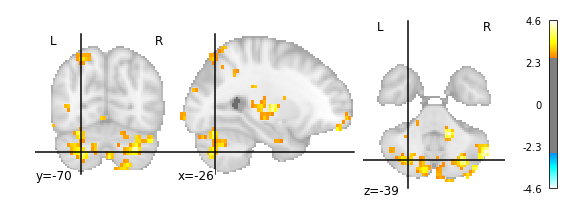

In [ ]:
nilearn.plotting.plot_stat_map(zmap, threshold=2.6)

## Do first-level analysis for all 26 subjects

In [ ]:
# Make an empty list to put fitted first level models in
models = []

for subj_idx in ['%02d' % i for i in range(1, 27)]:

    print("Subject %s" % subj_idx)

    # set up path
    path = os.path.join(os.environ['HOME'], 'data/openfmri/ds102/derivatives/fmriprep/sub-{subj_idx}/func/sub-{subj_idx}_task-flankertask'.format(**locals()))

    # Set up filenames
    data = [path + '_run-01_bold_space-MNI152NLin2009cAsym_preproc.nii.gz',
            path + '_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz']

    mask = path + '_run-01_bold_space-MNI152NLin2009cAsym_brainmask.nii.gz'

    confounds = [path+ '_run-01_bold_confounds.tsv',
                 path + '_run-02_bold_confounds.tsv']

    
    # Get paradigms
    paradigm = [get_onsets(subj_idx, '01'), get_onsets(subj_idx, '02')]
    
    # Set up model, we have to give:
    # * the TR (time it takes to acquire one functional volume)
    # * The HRF-model (we use a standard double-gamma model + derivative)
    # * The amount of smoothing (we use ample, 8.0 mm)
    # * The mask (Saves time, we do not estimate models outside of the brain)
    first_level_model = FirstLevelModel(t_r, hrf_model='glover + derivative', smoothing_fwhm=8.0, mask=mask)
    
    # Fit model, including all confounds (motion parameters, tcompcorr, etc.)
    first_level_model.fit(data, paradigm, confounds=confounds,)
    
    # Compute contrast incongruent > congruent
    zmap = first_level_model.compute_contrast('incongruent_correct - congruent_correct')
    
    # Plot resulting zmap, with (arbitrary but stringent) threshold at 2.6
    nilearn.plotting.plot_stat_map(zmap, threshold=2.6)

    
    # make list of models and subjects that we processed
    models.append(first_level_model)

Subject 01
Subject 02
Subject 03
Subject 04
Subject 05
Subject 06
Subject 07
Subject 08
Subject 09
Subject 10
Subject 11
Subject 12
Subject 13
Subject 14
Subject 15
Subject 16
Subject 17
Subject 18
Subject 19
Subject 20
Subject 21


/home/ubuntu/miniconda2/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Subject 22
Subject 23
Subject 24
Subject 25
Subject 26


# Second level (group) analysis

## Classical

In [ ]:
contrasts = [model.compute_contrast('incongruent_correct - congruent_correct') for model in models]

In [ ]:
design_matrix = pandas.DataFrame({'intercept':np.ones(len(contrasts))},
                                 index=np.arange(1, 27))

In [ ]:
design_matrix

In [ ]:
from nistats.second_level_model import SecondLevelModel
second_level_model = SecondLevelModel(smoothing_fwhm=0.0)
second_level_model = second_level_model.fit(contrasts, design_matrix=design_matrix)
z_map = second_level_model.compute_contrast('intercept')

In [ ]:
plotting.plot_stat_map(z_map, threshold=3.1 )

In [ ]:
z_map.to_filename('zmap.nii.gz')

In [ ]:
from IPython.display import FileLink
FileLink('zmap.nii.gz')

## Model-based

In [ ]:
drift_rates = pandas.read_csv('drift_rates.csv')

In [ ]:
drift_rates.head()

In [ ]:
design_matrix = pandas.DataFrame({'intercept':np.ones(len(contrasts))})
design_matrix['drift_difference'] = drift_rates['congruent'] - drift_rates['incongruent']
design_matrix['drift_difference'] -= design_matrix['drift_difference'].mean()

In [ ]:
# Do not smooth again
second_level_model = SecondLevelModel(smoothing_fwhm=0.0)
second_level_model = second_level_model.fit(contrasts, design_matrix=design_matrix)
z_map = second_level_model.compute_contrast('drift_difference')
z_map.to_filename('zmap_drift_difference.nii.gz')

FileLink('zmap_drift_difference.nii.gz')

In [ ]:
plotting.plot_stat_map(z_map, threshold=2.3 )

In [ ]:
z_map = second_level_model.compute_contrast('intercept')
plotting.plot_stat_map(z_map, threshold=2.3 )
z_map.to_filename('zmap_modelbased.nii.gz')
from IPython.display import FileLink
FileLink('zmap_modelbased.nii.gz')